Stack complete!
Stack shape: (1224, 1832)


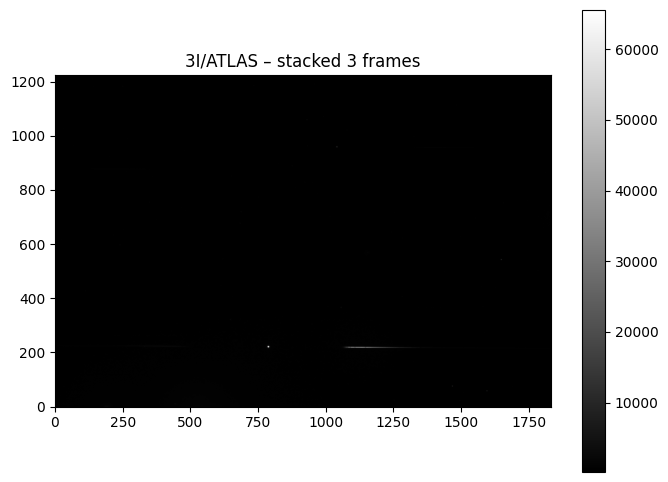

Saved: data_work/atlasl26_stacked_3.fits


In [1]:
# ==============================
# 0. Stacking file preparation
# ==============================
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# ==== 1. Specify the names of ALL FITS files here ====
files = [
"data_raw/atlasl26/121755m005759_20251126_055934_0_kzx3ri_m_cal.fit",
"data_raw/atlasl26/121755m005759_20251126_060127_0_j6dqyt_m_cal.fit",
"data_raw/atlasl26/121755m005759_20251126_060222_0_tgd5zi_m_cal.fit"
]

# ==== 2. Load frames into a list ====
frames = []

for fname in files:
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(np.float32)
        frames.append(data)

# ==== 3. File stacking ====
stacked = np.mean(frames, axis=0)

print("Stack complete!")
print("Stack shape:", stacked.shape)

# ==== 4. Quick preview of the results ====
plt.figure(figsize=(8,6))
plt.imshow(stacked, cmap='gray', origin='lower')
plt.colorbar()
plt.title("3I/ATLAS – stacked 3 frames")
plt.show()

# ==== 5. Save the final stacked file ====
fits.writeto("data_work/atlasl26_stacked_3.fits", stacked, overwrite=True)
print("Saved: data_work/atlasl26_stacked_3.fits")

Loaded stacked frame: (1224, 1832)


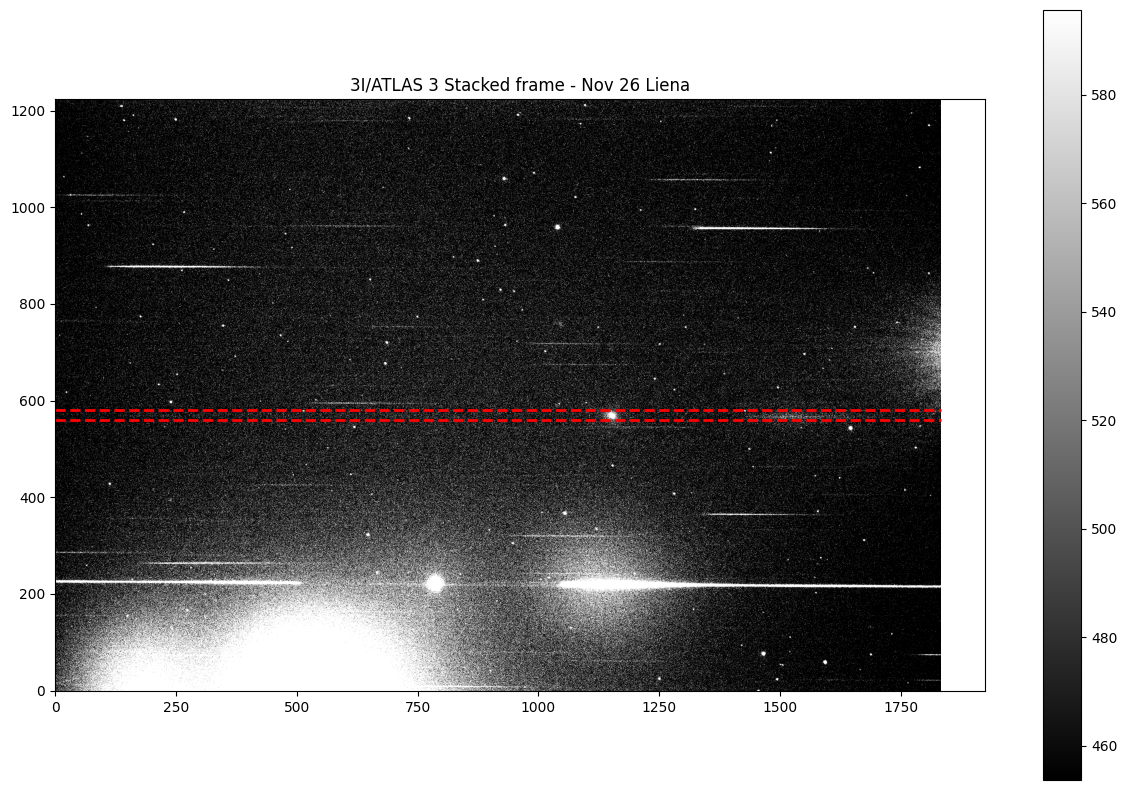

In [2]:
# =============================================
# 1. Preview of spectrum amd mark spectrum area
# =============================================

# In this step we visually inspect the stacked frame to locate the spectrum.
# We select the Y-pixel position of the spectral trace,
# which is required for further wavelength calibration and spectral extraction.

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# ==== 1. Upload stacked file ====
stack_path = "data_work/atlasl26_stacked_3.fits"

with fits.open(stack_path) as hdul:
    stacked = hdul[0].data.astype(float)

print("Loaded stacked frame:", stacked.shape)

# ==== 2. Quick view to select targeted area with spectrum ====
plt.figure(figsize=(15,10))
plt.imshow(stacked, cmap='gray', origin='lower', vmin=np.percentile(stacked,50), vmax=np.percentile(stacked,95))
plt.title("3I/ATLAS 3 Stacked frame - Nov 26 Liena")
plt.colorbar()
# --- Add red zone around spectrum ---
y_center = 570       # Y-pixel position
half_height = 10      # strip heith 

y_min = y_center - half_height
y_max = y_center + half_height

#Two red strips to mark spectrum area
plt.hlines([y_min, y_max], xmin=0, xmax=stacked.shape[1],
           colors='red', linestyles='--', linewidth=2)
plt.show()

Image shape (Y, X): (1224, 1832)
Spectrum stripe Y-range: 205 to 235


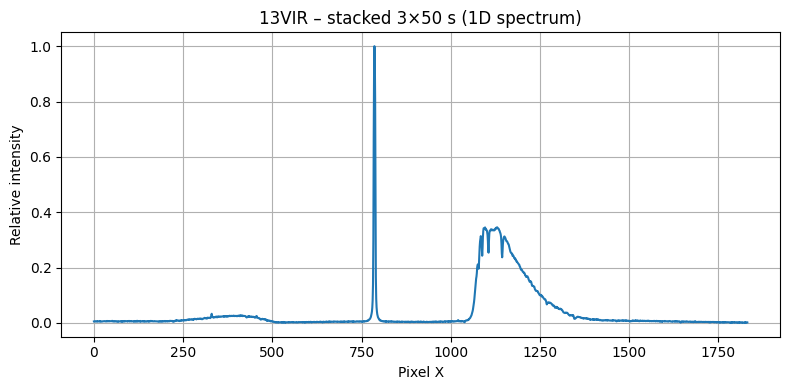

In [3]:
# =============================================
# 2. Reference Star Absorption Line Inspection
# =============================================

#This section extracts a raw 1D pixel-based spectrum of a reference star located in the same frame as 3I/ATLAS.
#The goal is to visually inspect the stellar spectrum and identify absorption features before wavelength calibration.

from astropy.io import fits
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Load stacked FITS
stack_path = Path("data_work/atlasl26_stacked_3.fits")
hdu = fits.open(stack_path)
img = hdu[0].data.astype(float)

print("Image shape (Y, X):", img.shape)

# --- Choose the spectrum stripe (use same Y-range as before) ---
# If you already know exact y_min, y_max from previous run – put them here.
y_center   = 220   # <- set to your known value
half_height = 15   # <- thickness of the stripe
y_min = y_center - half_height
y_max = y_center + half_height


print("Spectrum stripe Y-range:", y_min, "to", y_max)

stripe = img[y_min:y_max, :]

# Collapse stripe to 1D spectrum
spectrum_1d = stripe.mean(axis=0)

# --- Rough background estimate from regions above and below the stripe ---
bg_top  = img[0:y_min-20, :]
bg_bot  = img[y_max+20:, :]
bg_all  = np.vstack([bg_top, bg_bot])
bg_1d   = bg_all.mean(axis=0)

spectrum_clean = spectrum_1d - bg_1d
spectrum_clean -= spectrum_clean.min()      # shift to >= 0
spectrum_norm  = spectrum_clean / spectrum_clean.max()

x_pixels = np.arange(img.shape[1])

# --- Plot ---
plt.figure(figsize=(8, 4))
plt.plot(x_pixels, spectrum_norm)
plt.xlabel("Pixel X")
plt.ylabel("Relative intensity")
plt.title("13VIR – stacked 3×50 s (1D spectrum)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# ================================================
# 3. Finding pixel positions for dips (Hδ, Hγ, Hβ)
# ================================================

import numpy as np

# Use the spectrum from the previous cell
pix = x_pixels
spec = spectrum_norm   # or smooth_norm if you have it

mask1 = (pix > 1080) & (pix < 1095)   # Hδ window
mask2 = (pix > 1100) & (pix < 1120)   # Hγ window
mask3 = (pix > 1130) & (pix < 1150)   # Hβ window

idx1 = np.where(mask1)[0][0] + np.argmin(spec[mask1])
idx2 = np.where(mask2)[0][0] + np.argmin(spec[mask2])
idx3 = np.where(mask3)[0][0] + np.argmin(spec[mask3])

pix1 = pix[idx1]
pix2 = pix[idx2]
pix3 = pix[idx3]

print("Dip 1 (Hδ) Pixel:", pix1)
print("Dip 2 (Hγ) Pixel:", pix2)
print("Dip 3 (Hβ) Pixel:", pix3)

Dip 1 (Hδ) Pixel: 1088
Dip 2 (Hγ) Pixel: 1106
Dip 3 (Hβ) Pixel: 1144


In [5]:
# ========================================================
# 4. METHOD A - Computing spectral dispersion from Hγ & Hβ
# ========================================================

#Method A is initial estimate

# Known laboratory wavelengths of hydrogen lines (nm)
lambda_Hg = 434.05   # nm, Hγ
lambda_Hb = 486.13   # nm, Hβ

# Pixel positions of the same lines measured from the spectrum
pix_Hg = pix2
pix_Hb = pix3

# Compute linear dispersion (nm per pixel)
dispersion = (lambda_Hb - lambda_Hg) / (pix_Hb - pix_Hg)

print("Computed dispersion (nm/px):", dispersion)

Computed dispersion (nm/px): 1.3705263157894734


Candidate absorption features:
 pixel_x   lambda_nm   depth_rel
   1088     409.38      0.243
   1106     434.05      0.254
   1144     486.13      0.237


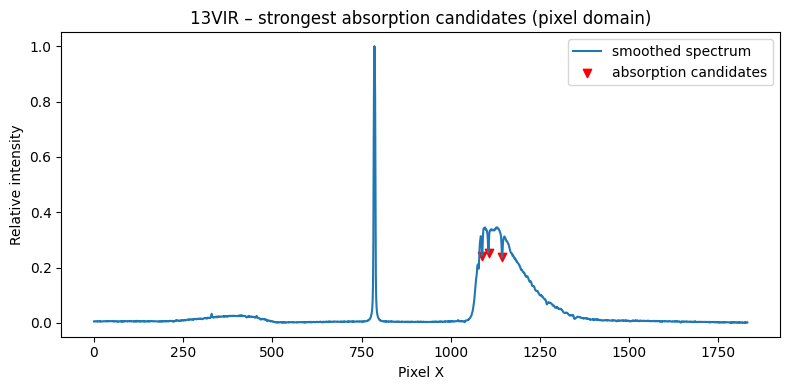

In [6]:
# ==========================================
# 5. Finding absorption candidates (13 Vir)
# ==========================================
# Goal:
# 1) Automatically detect the strongest absorption dips in a chosen X-range
# 2) Convert their pixel positions to wavelengths using Method A calibration:
#       lambda = lambda_ref + dispersion * (pixel - pixel_ref)


from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Use the normalized 1D spectrum from the previous cell ---
smooth_norm = spectrum_norm

# --- 2) Invert the spectrum so absorption dips become "peaks" for find_peaks() ---
inv = 1.0 - smooth_norm

# --- 3) Limit to the region where Balmer dips are expected (tune if needed) ---
region_mask = (x_pixels > 1000) & (x_pixels < 1400)

x_reg    = x_pixels[region_mask]
inv_reg  = inv[region_mask]
spec_reg = smooth_norm[region_mask]

# --- 4) Find absorption candidates (in inverted spectrum they are peaks) ---
peaks, props = find_peaks(inv_reg, prominence=0.03)  # tune 0.02–0.05 if needed

abs_pixels = x_reg[peaks]
abs_depth  = spec_reg[peaks]

# --- 5) Convert candidate pixels to wavelength (Method A: 2-line estimate) ---
lambda_ref = 486.13   # nm, laboratory Hβ wavelength
pixel_ref  = pix_Hb   # pixel position of Hβ dip measured earlier (pix3)
# dispersion is taken from Method A (computed in the previous cell)

abs_lambda = lambda_ref + dispersion * (abs_pixels - pixel_ref)

print("Candidate absorption features:")
print(" pixel_x   lambda_nm   depth_rel")
for px, lam, d in zip(abs_pixels, abs_lambda, abs_depth):
    print(f"{int(px):7d}   {lam:8.2f}   {d:8.3f}")

# --- 6) Plot: spectrum + detected dips ---
plt.figure(figsize=(8,4))
plt.plot(x_pixels, smooth_norm, label="smoothed spectrum")
plt.scatter(abs_pixels, abs_depth, marker="v", color="red", label="absorption candidates")
plt.xlabel("Pixel X")
plt.ylabel("Relative intensity")
plt.title("13VIR – strongest absorption candidates (pixel domain)")
plt.legend()
plt.tight_layout()
plt.show()

Balmer absorption features in zoomed region:
 pixel_x   lambda_nm   depth_rel
   1088     409.38      0.243
   1106     434.05      0.254
   1144     486.13      0.237


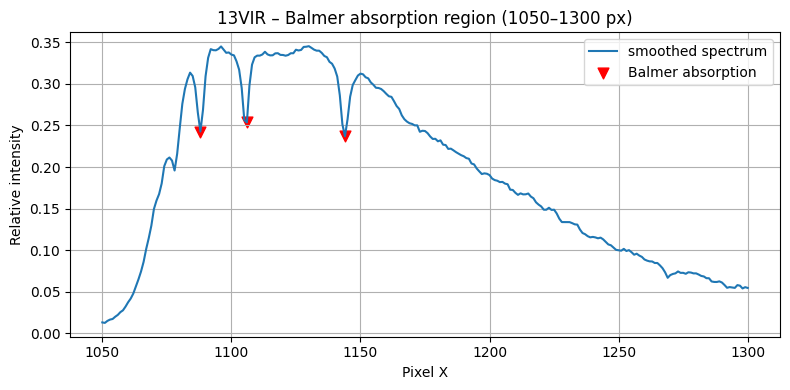

In [7]:
# =====================================================
# 6. Zoomed-in view of the Balmer absorption region
# =====================================================

# 1) Define the X-range for a clean zoom plot
x_min_zoom = 1050
x_max_zoom = 1300

zoom_mask = (x_pixels >= x_min_zoom) & (x_pixels <= x_max_zoom)
x_zoom    = x_pixels[zoom_mask]
y_zoom    = smooth_norm[zoom_mask]

# 2) Keep only the detected absorption pixels inside the zoom range
abs_mask_zoom = (abs_pixels >= x_min_zoom) & (abs_pixels <= x_max_zoom)
abs_x_zoom    = abs_pixels[abs_mask_zoom]
abs_lam_zoom  = abs_lambda[abs_mask_zoom]
abs_d_zoom    = abs_depth[abs_mask_zoom]

# IMPORTANT:
# abs_pixels are X positions (pixel coordinates). We must map them to indices
# in the x_pixels array to fetch the corresponding y-values reliably.
abs_idx_zoom = np.array([np.where(x_pixels == px)[0][0] for px in abs_x_zoom], dtype=int)
abs_y_zoom   = smooth_norm[abs_idx_zoom]

# 3) Print a compact table for the zoomed region
print("Balmer absorption features in zoomed region:")
print(" pixel_x   lambda_nm   depth_rel")
for px, lam, d in zip(abs_x_zoom, abs_lam_zoom, abs_d_zoom):
    print(f"{int(px):7d}   {lam:8.2f}   {d:8.3f}")

# 4) Plot the zoomed spectrum with markers
plt.figure(figsize=(8, 4))
plt.plot(x_zoom, y_zoom, label="smoothed spectrum")
plt.scatter(abs_x_zoom, abs_y_zoom, marker="v", s=60, color="red", label="Balmer absorption")
plt.xlabel("Pixel X")
plt.ylabel("Relative intensity")
plt.title(f"13VIR – Balmer absorption region ({x_min_zoom}–{x_max_zoom} px)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Method B calibration (3 Balmer lines):
lambda = 1.358613 * pixel + -1068.234
Dispersion ≈ 1.358613 nm / pixel


Residuals at Balmer lines:
Hδ: pixel=1088.00  lambda_true= 410.17 nm  lambda_model= 409.94 nm  delta= -0.232 nm
Hγ: pixel=1106.00  lambda_true= 434.05 nm  lambda_model= 434.39 nm  delta= +0.343 nm
Hβ: pixel=1144.00  lambda_true= 486.13 nm  lambda_model= 486.02 nm  delta= -0.110 nm


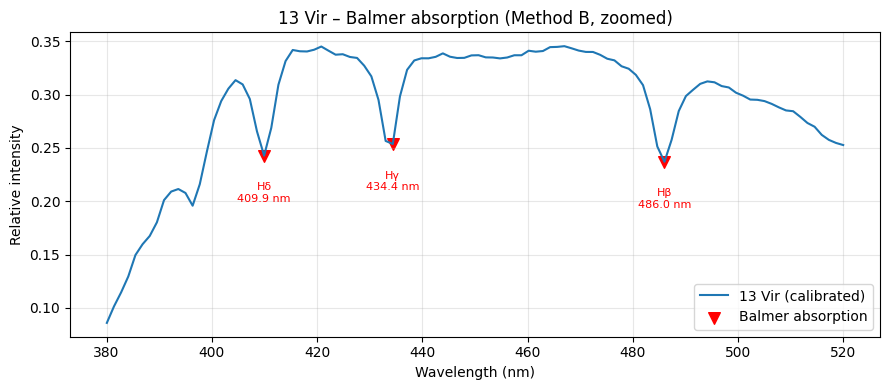

In [8]:
# =====================================================
# 7. METHOD B – 3-line linear calibration (Hδ, Hγ, Hβ)
# =====================================================
# This method fits a linear wavelength calibration:
#     lambda = a * pixel + b
# using three Balmer absorption lines of the reference star.
# The plot is intentionally ZOOMED to the Balmer region only.

import numpy as np
import matplotlib.pyplot as plt

# --- 1) Use the same spectrum as before ---
spec = spectrum_norm  # or smooth_norm if you prefer

# --- 2) Pixel positions of Balmer dips (from Method A cell) ---
pix_Hd = float(pix1)   # Hδ
pix_Hg = float(pix2)   # Hγ
pix_Hb = float(pix3)   # Hβ

# --- 3) Laboratory wavelengths (nm) ---
lam_Hd = 410.17
lam_Hg = 434.05
lam_Hb = 486.13

pixels_cal = np.array([pix_Hd, pix_Hg, pix_Hb])
lambda_cal = np.array([lam_Hd, lam_Hg, lam_Hb])

# --- 4) Linear calibration: lambda = a*pixel + b ---
a, b = np.polyfit(pixels_cal, lambda_cal, deg=1)

print("Method B calibration (3 Balmer lines):")
print(f"lambda = {a:.6f} * pixel + {b:.3f}")
print(f"Dispersion ≈ {a:.6f} nm / pixel\n")

# --- Residuals table at Balmer calibration points (human-readable) ---
print("\nResiduals at Balmer lines:")
for pix, lam_true, name in zip(pixels_cal, lambda_cal, ["Hδ", "Hγ", "Hβ"]):
    lam_model = a * pix + b
    delta = lam_model - lam_true
    print(
        f"{name}: pixel={pix:7.2f}  "
        f"lambda_true={lam_true:7.2f} nm  "
        f"lambda_model={lam_model:7.2f} nm  "
        f"delta={delta:+7.3f} nm"
    )

# --- 6) Apply calibration ---
lambda_axis = a * x_pixels + b

# --- 7) ZOOMED plot around Balmer region ---
wl_min = 380
wl_max = 520
mask = (lambda_axis >= wl_min) & (lambda_axis <= wl_max)

# Exact marker positions (sit on the curve)
dip_wls  = a * pixels_cal + b
dip_vals = spec[[idx1, idx2, idx3]]
dip_names = ["Hδ", "Hγ", "Hβ"]

plt.figure(figsize=(9, 4))
plt.plot(lambda_axis[mask], spec[mask], label="13 Vir (calibrated)")

plt.scatter(dip_wls, dip_vals, marker="v", color="red", s=70, label="Balmer absorption")

for wl, val, name in zip(dip_wls, dip_vals, dip_names):
    plt.text(wl, val - 0.025, f"{name}\n{wl:.1f} nm",
             ha="center", va="top", fontsize=8, color="red")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative intensity")
plt.title("13 Vir – Balmer absorption (Method B, zoomed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# ==========================================
# 8. Zero-order based anchor calculation
# ==========================================
# This cell computes the 3I/ATLAS anchor pixel
# using zero-order positions on the same frame

# --- Measured zero-order (ball) positions ---
# The simplest way to determine the zero-order position is to
# open the stacked FITS file in DS9,
# place the cursor over the center of the zero-order image,
# and read the X pixel value from the status bar.

x0_star  = 788    # X pixel of zero-order for 13 Vir
x0_atlas = 1153   # X pixel of zero-order for ATLAS

# --- Known spectral line on the star ---
x_Hb_star = 1144      # pixel position of Hβ in 13 Vir spectrum
lambda_Hb = 486.13    # nm (Hβ)

# --- Offset from zero-order to Hβ (instrument geometry) ---
delta_x = x_Hb_star - x0_star

# --- apply this offset to 3I/ATLAS ---
pixel_ref_atlas = x0_atlas + delta_x

print("Zero-order star (x0_star):", x0_star)
print("Zero-order ATLAS (x0_atlas):", x0_atlas)
print("Δx (Hβ − zero-order):", delta_x)
print("ATLAS anchor pixel (pixel_ref_atlas):", pixel_ref_atlas)

Zero-order star (x0_star): 788
Zero-order ATLAS (x0_atlas): 1153
Δx (Hβ − zero-order): 356
ATLAS anchor pixel (pixel_ref_atlas): 1509


3I/ATLAS frame shape: (1224, 1832)
3I/ATLAS stripe shape: (20, 1832)


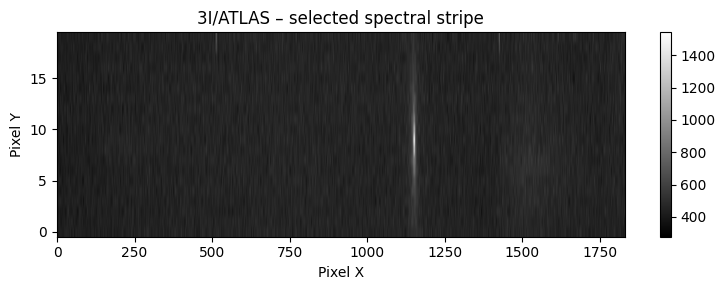

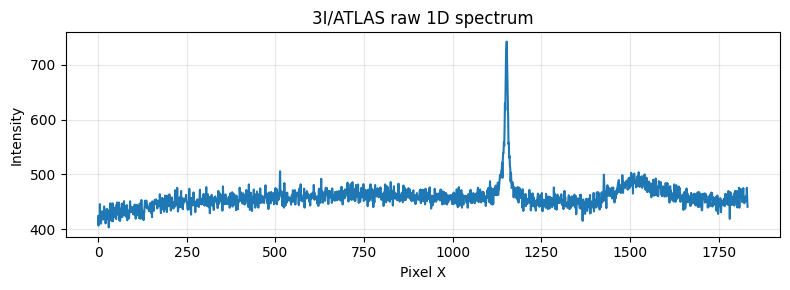

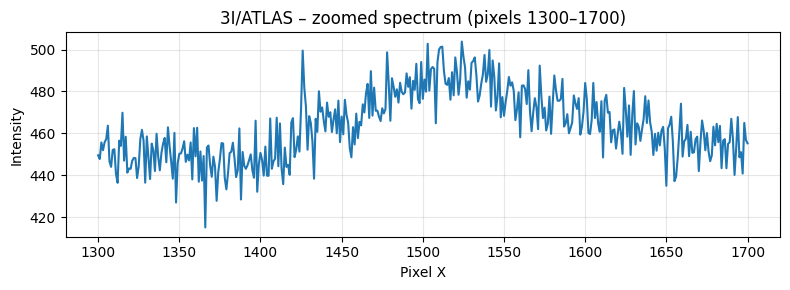

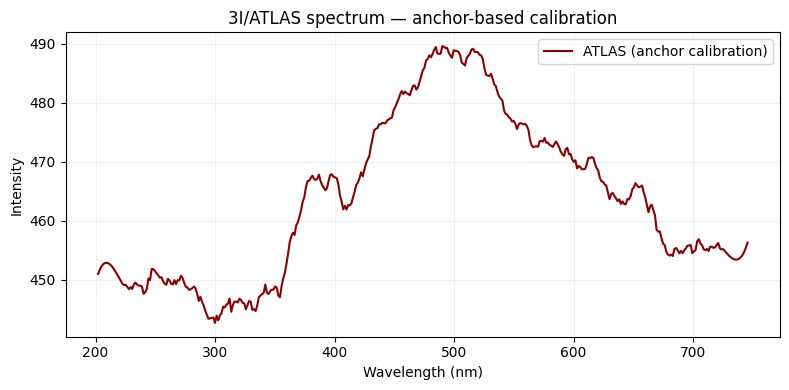

In [10]:
# ====================================================================
# 9. Anchor-based calibration for 3I/ATLAS with 13VIR dispersion value 
# ====================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# --- Anchor parameters ---
lambda_ref = 486.13      # nm, Hβ
pixel_ref = 1509         # ATLAS anchor pixel (from the previous cell)
dispersion = 1.358613    # nm per pixel 


# ==============================
# 3I/ATLAS spectrum extraction
# ==============================

# >>> 3I/ATLAS PARAMETERS <<<
y_center_atlas   = 570     # vertical position of 3I/ATLAS trace (pixels)
half_height      = 10      # half-height of extraction stripe
coma_end         = 1200    # pixel where coma contribution is cut
x_min_pix_atlas  = 1300    # left pixel boundary
x_max_pix_atlas  = 1700    # right pixel boundary

ny, nx = stacked.shape
print("3I/ATLAS frame shape:", stacked.shape)

# --- extract spectral stripe ---
y_min = int(y_center_atlas - half_height)
y_max = int(y_center_atlas + half_height)

stripe_atlas = stacked[y_min:y_max, :]
print("3I/ATLAS stripe shape:", stripe_atlas.shape)

plt.figure(figsize=(8,3))
plt.imshow(stripe_atlas, cmap="gray", origin="lower", aspect="auto")
plt.title("3I/ATLAS – selected spectral stripe")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.colorbar()
plt.tight_layout()
plt.show()

# --- collapse stripe to 1D spectrum ---
atlas_1d = stripe_atlas.mean(axis=0)
pixel_full = np.arange(nx)

plt.figure(figsize=(8,3))
plt.plot(pixel_full, atlas_1d)
plt.xlabel("Pixel X")
plt.ylabel("Intensity")
plt.title("3I/ATLAS raw 1D spectrum")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- cut coma + zoom X range ---
pixel_clean = pixel_full[coma_end:]
spec_clean  = atlas_1d[coma_end:]

mask = (pixel_clean >= x_min_pix_atlas) & (pixel_clean <= x_max_pix_atlas)
pix_zoom = pixel_clean[mask]
spec_zoom = spec_clean[mask]

plt.figure(figsize=(8,3))
plt.plot(pix_zoom, spec_zoom)
plt.xlabel("Pixel X")
plt.ylabel("Intensity")
plt.title(f"3I/ATLAS – zoomed spectrum (pixels {x_min_pix_atlas}–{x_max_pix_atlas})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- smoothing ---
smooth = savgol_filter(spec_zoom, window_length=31, polyorder=3)

# ===================================
# Anchor-based wavelength calibration
# ===================================

wavelengths = lambda_ref + dispersion * (pix_zoom - pixel_ref)

# ==============================
# Final calibrated plot
# ==============================

plt.figure(figsize=(8,4))
plt.plot(wavelengths, smooth, color="darkred", label="ATLAS (anchor calibration)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("3I/ATLAS spectrum — anchor-based calibration")
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

3I/ATLAS peaks (wavelength [nm], intensity):
 386.95 nm     467.8
 397.82 nm     467.8
 490.21 nm     489.6
 516.02 nm     489.1
 615.20 nm     470.8


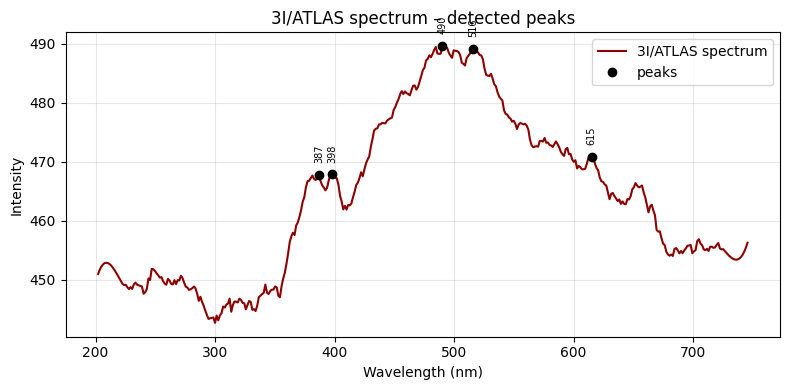

In [11]:
# ====================================================================
# 10. 3I/ATLAS final spectrum with peaks in nm
# ====================================================================

from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# We assume the previous cell already created:
# wavelengths  -> wavelength axis for 3I/ATLAS
# smooth       -> smoothed 3I/ATLAS spectrum (same length as wavelengths)

# ---- 1. Find peaks on the smoothed 3I/ATLAS spectrum ----
peaks_idx, props = find_peaks(
    smooth,
    prominence=2,   # tune if needed
    distance=3,
    width=4
)

peak_wavelengths = wavelengths[peaks_idx]
peak_values      = smooth[peaks_idx]

# ---- Select 5 strongest peaks ----
top_n = 5
top_idx = np.argsort(peak_values)[-top_n:]   # 5 strongest peaks
top_idx = np.sort(top_idx)                   # peak sorting 

peak_wavelengths = peak_wavelengths[top_idx]
peak_values      = peak_values[top_idx]

print("3I/ATLAS peaks (wavelength [nm], intensity):")
for wl, val in zip(peak_wavelengths, peak_values):
    print(f"{wl:7.2f} nm   {val:7.1f}")

# ---- 2. Plot spectrum and mark peaks ----
plt.figure(figsize=(8,4))
plt.plot(wavelengths, smooth, label="3I/ATLAS spectrum", color="darkred")
plt.plot(peak_wavelengths, peak_values, "ko", label="peaks")

for wl, val in zip(peak_wavelengths, peak_values):
    plt.text(wl, val + 2, f"{wl:.0f}", ha="center", va="bottom", fontsize=7, rotation=90)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("3I/ATLAS spectrum – detected peaks")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()